# CGANs - Conditional Generative Adversarial Nets

Introduction to Conditional Generative Adversarial Nets or CGANs.

This notebook is organized follows:

1. **Background**
* **Definition**
* **Training CGANs with CIFAR-10 dataset, Keras and TensorFlow**


## 1. Background

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The value function $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$


## 2. Definition

Generative adversarial nets can be extended to a **conditional model** if both the generator and discriminator are conditioned on some extra information $y$. 

* $y$ could be any kind of auxiliary information, such as class labels or data from other modalities. 

We can perform the conditioning by feeding $y$ into the both the discriminator and generator as additional input layer.

### Generator

The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation, and the adversarial training framework allows for considerable flexibility in how this hidden representation is composed.

### Discriminator

$x$ and $y$ are presented as inputs and to a discriminative function.

### Value function

$$ \underset{G}{min} \: \underset{D}{max} \; V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x|y)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z|y)))]$$

### Structure

![cgan](../../img/cgan.png)

## 3. Training CGANs with CIFAR-10 dataset, Keras and TensorFlow

A CGANs implementation using the transposed convolution and convolution neural network, concatenate layers and the [Keras](https://keras.io/) library.

### 1. Load data

#### Load libraries

In [2]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.layers import Concatenate, GaussianNoise,Activation
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras import initializers
from keras import backend as K

Using TensorFlow backend.


#### Getting the data

In [4]:

# cached images
cached_images = '/Volumes/Samsung_T3/bathy_training/cache_images_ohara_07.npz'

# cached bathymetry 
cached_bpatches = '/Volumes/Samsung_T3/bathy_training/cache_bpatches_ohara_07.npz'


# load dataset
data =  np.load(cached_images)
Ximg_train = data['xtrain']
data = np.load(cached_bpatches)
Xbathy_train = data['xtrain']




#### Explore visual data

The images are AUV thumbnails and bathy is a corresponding patch around image location

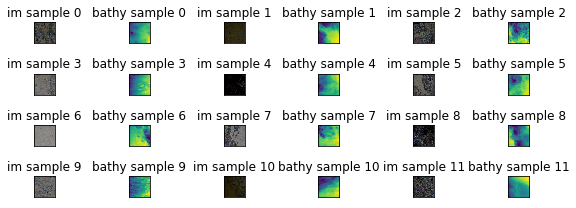

In [5]:
num_samples = 12
fig = plt.figure(figsize=(8,3))
for i in range(num_samples):
    ax = plt.subplot(4, 6, 1 + 2*i, xticks=[], yticks=[])
    img_num = np.random.randint(Ximg_train.shape[0])
    img = Ximg_train[img_num,::]
    ax.set_title("im sample " + str(i))
    plt.imshow(img)
    
    bpatch = Xbathy_train[img_num,:,:,0]
    ax = plt.subplot(4, 6, 1 + 2*i+1, xticks=[], yticks=[])
    ax.set_title("bathy sample " + str(i))
    plt.imshow(bpatch)
    
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [7]:
print('Ximg_train shape:', Ximg_train.shape)
print('Xbathy_train shape:', Xbathy_train.shape)
print(Ximg_train.shape[0], 'train img samples')
print(Xbathy_train.shape[0], 'train bathy samples')

Ximg_train shape: (11278, 64, 64, 3)
Xbathy_train shape: (11278, 21, 21, 1)
11278 train img samples
11278 train bathy samples


In [6]:
##if K.image_data_format() == 'channels_first':
##    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
##    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
##    input_shape = (3, 32, 32)
##else:
##    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
##    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
##    input_shape = (32, 32, 3)
    
### convert class vectors to binary class matrices
##Y_train = np_utils.to_categorical(y_train, num_classes)
##Y_test = np_utils.to_categorical(y_test, num_classes)

### the generator is using tanh activation, for which we need to preprocess 
### the image data into the range between -1 and 1.

##X_train = np.float32(X_train)
##X_train = (X_train / 255 - 0.5) * 2
##X_train = np.clip(X_train, -1, 1)

##X_test = np.float32(X_test)
##X_test = (X_test / 255 - 0.5) * 2
##X_test = np.clip(X_test, -1, 1)

##print('X_train reshape:', X_train.shape)
##print('X_test reshape:', X_test.shape)

X_train reshape: (50000, 32, 32, 3)
X_test reshape: (10000, 32, 32, 3)


In [9]:
print(Ximg_train[0].shape)

(64, 64, 3)


### 2. Define model

#### Generator

In [25]:
# latent space dimension
z = Input(shape=(100,))

# bathy
bpatch = Input(shape=Xbathy_train[0].shape)
bvec = Flatten()(bpatch)

# Generator network
merged_layer = Concatenate()([z, bvec])

# FC: 2x2x512
generator = Dense(2*2*512, activation='relu')(merged_layer)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)
generator = Reshape((2, 2, 512))(generator)

# # Conv 1: 4x4x256
generator = Conv2DTranspose(256, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 2: 8x8x128
generator = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 3: 16x16x64
generator = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)


# Conv 4: 32x32x32
generator = Conv2DTranspose(32, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 5: 64x64x3
generator = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(generator)

# generator = Model(inputs=[z, labels], outputs=out_g)
generator = Model(inputs=[z, bpatch], outputs=generator, name='generator')

#### Generator model visualization

In [26]:
# prints a summary representation of your model
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 21, 21, 1)    0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 441)          0           input_16[0][0]                   
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 541)          0           input_15[0][0]                   
                                                                 flatten_8[0][0]                  
__________

#### Discriminator

In [27]:
# input image
img_input = Input(shape=(Ximg_train[0].shape))

# bathy conditioning
bpatch = Input(shape=Xbathy_train[0].shape)
bvec = Flatten()(bpatch)

# Conv 1: 16x16x64
discriminator = Conv2D(64, kernel_size=5, strides=2, padding='same')(img_input)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 2:
discriminator = Conv2D(128, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 3: 
discriminator = Conv2D(256, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 4: 
discriminator = Conv2D(512, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# FC
discriminator = Flatten()(discriminator)

# Concatenate 
merged_layer = Concatenate()([discriminator, bvec])
discriminator = Dense(512, activation='relu')(merged_layer)
    
# Output
discriminator = Dense(1, activation='sigmoid')(discriminator)

discriminator = Model(inputs=[img_input, bpatch], outputs=discriminator, name='discriminator')

#### Discriminator model visualization

In [28]:
# prints a summary representation of your model
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 32, 32, 64)   4864        input_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 32, 32, 64)   256         conv2d_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_22 (LeakyReLU)      (None, 32, 32, 64)   0           batch_normalization_22[0][0]     
__________________________________________________________________________________________________
conv2d_10 

### 3. Compile model

#### Compile discriminator

In [29]:
# # Optimizer
discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

#### Combined network

In [30]:
discriminator.trainable = False

bpatch = Input(shape=Xbathy_train[0].shape, name='bpatch')
z = Input(shape=(100,), name='z')

fake_img = generator([z, bpatch])
validity = discriminator([fake_img, bpatch])

d_g = Model([z, bpatch], validity, name='adversarial')

d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [31]:
# prints a summary representation of your model
d_g.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z (InputLayer)                  (None, 100)          0                                            
__________________________________________________________________________________________________
bpatch (InputLayer)             (None, 21, 21, 1)    0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 64, 64, 3)    5475011     z[0][0]                          
                                                                 bpatch[0][0]                     
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            8731521     generator[1][0]                  
          

### 4. Fit model


In [ ]:
epochs = 100
batch_size = 32
smooth = 0.1
latent_dim = 100

# adversarial ground-truths
real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(Ximg_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = Ximg_train[i*batch_size:(i+1)*batch_size]
        #real_labels = to_categorical(y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=10)
        bpatch_batch = Xbathy_train[i*batch_size:(i+1)*batch_size]
        
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, bpatch_batch],
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        
        
        X_fake = generator.predict_on_batch([z, bpatch_batch])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, bpatch_batch], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        
        # this is selecting random patches from within training set - ideally it would be from all the bathymetry
        
        idx = np.random.randint(0, Xbathy_train.shape[0], batch_size)
        random_bathy = Xbathy_train[idx]
        
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_bathy], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(Ximg_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        idx = np.random.randint(0, Xbathy_train.shape[0], samples)
        random_bathy = Xbathy_train[idx]
        
        
        x_fake = generator.predict([z, random_bathy])
        x_fake = np.clip(x_fake, -1, 1)
        x_fake = (x_fake + 1) * 127
        x_fake = np.round(x_fake).astype('uint8')

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(x_fake[k])
            plt.title(class_names[k])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

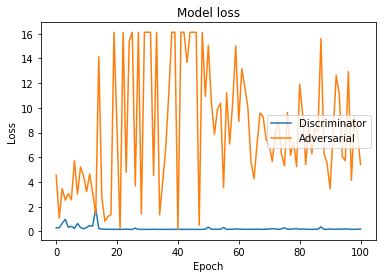

In [16]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

## References

* [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf)
* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
* [The CIFAR-10 dataset](https://www.cs.toronto.edu/%7Ekriz/cifar.html)
* [Keras-GAN](https://github.com/eriklindernoren/Keras-GAN)